# Filtros recursivos, o de respuesta al impulso infinita (IIR)
<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 

En este notebook se ejemplifica el diseño de filtros IIR mediante las funciones de síntesis digital directa de scipy.signal.

* Funciones de análisis de sistemas lineales: [plot_plantilla]() 


Se inicializa el entorno de simulación con los módulos utilizados.


In [1]:

import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

from pytc2.sistemas_lineales import plot_plantilla


### Diseño digital directo

Dejando atrás el método de la transformada bilineal, pasamos a los métodos directos, donde las funciones de diseño operan directamente sobre una plantilla completamente digital. Esto simplifica enormemente el diseño, como se mostrará en los siguientes ejemplos, a partir de la plantilla que usamos en el [notebook anterior](sintesis_digital_bilineal.ipynb):


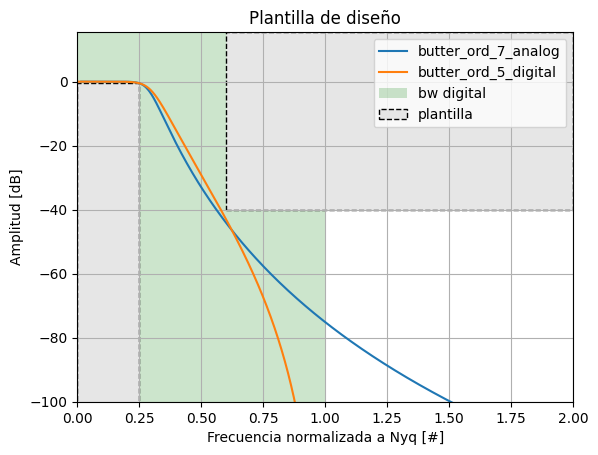

In [2]:
# Tipo de aproximación.
        
aprox_name = 'butter'
# aprox_name = 'cheby1'
# aprox_name = 'cheby2'
# aprox_name = 'ellip'

# Por qué no hay bessel ?
#aprox_name = 'bessel'

# Requerimientos de plantilla

filter_type = 'lowpass'
# filter_type = 'highpass'
# filter_type = 'bandpass'
# filter_type = 'bandstop'


# plantillas normalizadas a Nyquist y en dB

if filter_type == 'lowpass':

    # fpass = 1/2/np.pi # 
    fpass = 0.25 # 
    ripple = 0.5 # dB
    fstop = 0.6 # Hz
    attenuation = 40 # dB

elif filter_type == 'highpass':

    fpass = 0.6 
    ripple = 0.5 # dB
    fstop = 0.25
    attenuation = 40 # dB

elif filter_type == 'bandpass':

    fpass = np.array( [0.4, 0.6] ) 
    ripple = 0.5 # dB
    fstop = np.array( [0.25, 0.75] ) 
    attenuation = 40 # dB
    
else:

    # bandstop
    fpass = np.array( [0.25, 0.75] ) 
    ripple = 0.5 # dB
    fstop = np.array( [0.4, 0.6] ) 
    attenuation = 40 # dB


    # Cálculo del filtro

# frecuencia de muestreo normalizada (Nyquist = 1)
fs = 2

if aprox_name == 'butter':

    order, wcutof = sig.buttord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.buttord( fpass, fstop, ripple, attenuation, analog=False)

elif aprox_name == 'cheby1':

    order, wcutof = sig.cheb1ord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.cheb1ord( fpass, fstop, ripple, attenuation, analog=False)
    
elif aprox_name == 'cheby2':

    order, wcutof = sig.cheb2ord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.cheb2ord( fpass, fstop, ripple, attenuation, analog=False)
    
elif aprox_name == 'ellip':
   
    order, wcutof = sig.ellipord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.ellipord( fpass, fstop, ripple, attenuation, analog=False)


# Diseño del filtro analógico

num, den = sig.iirfilter(order, wcutof, rp=ripple, rs=attenuation, btype=filter_type, analog=True, ftype=aprox_name)

my_analog_filter = sig.TransferFunction(num,den)
my_analog_filter_desc = aprox_name + '_ord_' + str(order) + '_analog'

# Diseño del filtro digital

numz, denz = sig.iirfilter(orderz, wcutofz, rp=ripple, rs=attenuation, btype=filter_type, analog=False, ftype=aprox_name)

my_digital_filter = sig.TransferFunction(numz, denz, dt=1/fs)
my_digital_filter_desc = aprox_name + '_ord_' + str(orderz) + '_digital'



# Plantilla de diseño

plt.figure(1)
plt.cla()

npoints = 1000
w_nyq = 2*np.pi*fs/2

w, mag, _ = my_analog_filter.bode(npoints)
plt.plot(w/w_nyq, mag, label=my_analog_filter_desc)

w, mag, _ = my_digital_filter.bode(npoints)
plt.plot(w/w_nyq, mag, label=my_digital_filter_desc)

plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

plt.gca().set_xlim([0, 2])

plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)


En el ejemplo anterior, se observa que la función de diseño digital (y analógico) opera directamente sobre la plantilla y calcula el orden y la frecuencia de corte del filtro, para luego proceder directamente al cálculo de los coeficientes de la función que dan lugar al filtro. Esto se realiza con dos funciones, y como se verá más adelante, puede simplificarse a una sola función.

Sin embargo, el diseño **ya no es iterativo**, se obtiene el filtro deseado en un solo paso, y como ya se mostró con anterioridad, el filtro digital es de menor orden que el analógico **para esta plantilla en concoreto**.

Se verá en el ejemplo final, cómo se simplifica al máximo el diseño de filtros mediante la función [iirdesign](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirdesign.html) de [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html).

In [3]:

# re-Diseño del filtro analógico
num, den = sig.iirdesign(wp = fpass *2*np.pi*fs/2,
                         ws = fstop *2*np.pi*fs/2,
                         gpass = ripple,
                         gstop = attenuation,
                         ftype=aprox_name,
                         output = 'ba',
                         analog=True)

my_analog_filter = sig.TransferFunction(num,den)
my_analog_filter_desc = aprox_name + '_ord_' + str(order) + '_analog'


# re-Diseño del filtro digital
numz, denz = sig.iirdesign(wp = fpass,
                         ws = fstop,
                         gpass = ripple,
                         gstop = attenuation,
                         ftype=aprox_name,
                         output = 'ba',
                         analog=False,
                         fs = fs)


Se observa cómo se simplifica enormemente el diseño de los filtros con los métodos directos. El siguiente paso será el análisis de sus respuestas en frecuencia.

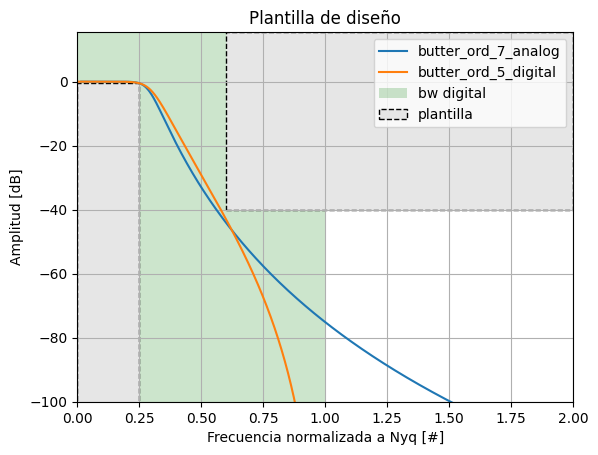

In [4]:
my_digital_filter = sig.TransferFunction(numz, denz, dt=1/fs)
my_digital_filter_desc = aprox_name + '_ord_' + str(orderz) + '_digital'


# Plantilla de diseño

plt.figure(1)
plt.cla()

npoints = 1000
w_nyq = 2*np.pi*fs/2

w, mag, _ = my_analog_filter.bode(npoints)
plt.plot(w/w_nyq, mag, label=my_analog_filter_desc)

w, mag, _ = my_digital_filter.bode(npoints)
plt.plot(w/w_nyq, mag, label=my_digital_filter_desc)

plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

plt.gca().set_xlim([0, 2])

plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)



El resultado es exactamente el mismo que con los métodos anteriores, con algunas ventajas. En caso que la plantilla de diseño sea más exigente, y en consecuencia el filtro sea de **mayor orden**, se puede pedir que el filtro se implemente como una cascada de secciones de segundo orden (**SOS**).

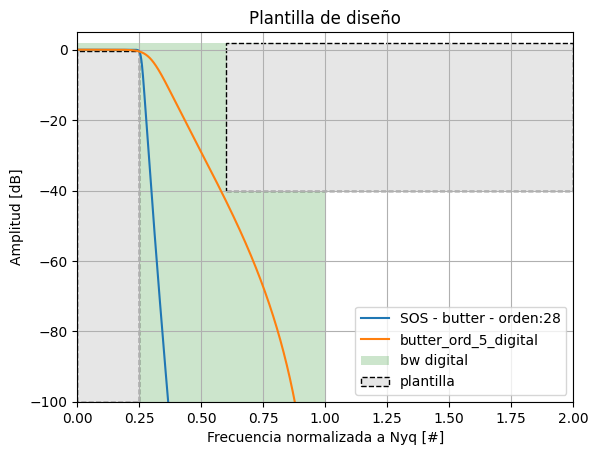

In [5]:

# Diseño del filtro digital más exigente
sos_filter = sig.iirdesign(  wp = fpass,
                             ws = fpass+0.05,
                             gpass = ripple,
                             gstop = attenuation,
                             ftype=aprox_name,
                             output = 'sos',
                             analog=False,
                             fs = fs)

otra_desc = 'SOS - {:s} - orden:{:d}'.format(aprox_name, sos_filter.shape[0]*2)


# Plantilla de diseño

plt.figure(1)
plt.cla()

npoints = 1000

w, hh = sig.sosfreqz(sos_filter, worN=npoints)
plt.plot(w/np.pi, 20*np.log10(np.abs(hh)), label=otra_desc)

# filtro anterior, como referencia
w, mag, _ = my_digital_filter.bode(npoints)
plt.plot(w/w_nyq, mag, label=my_digital_filter_desc)

plt.title('Plantilla de diseño')
plt.xlabel('Frecuencia normalizada a Nyq [#]')
plt.ylabel('Amplitud [dB]')
plt.grid(which='both', axis='both')

plt.gca().set_xlim([0, 2])
plt.gca().set_ylim([-100, 2])

plot_plantilla(filter_type = filter_type , fpass = fpass, ripple = ripple , fstop = fstop, attenuation = attenuation, fs = fs)
